<a href="https://colab.research.google.com/github/hongqin/quantum_sandbox/blob/main/QML_WorkShop2024_Chapter_2_Neural_Network_Classifier_and_Regressor_shared_audiences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Author__ : "Amin Amiri"

__Supervisors__ : "Dr. Yu Liang and Dr. Dalei Wu"

__Version__ : "v07072024-2040"


__*The University of Tennessee at Chattanooga*__

[Reference](https://qiskit-community.github.io/qiskit-machine-learning/index.html)

**ansatz Definition:**

The term ansatz is a **German word** that means **"approach" or "initial guess."** In scientific contexts, it is used to refer to an assumed form for a solution to a problem, which is then optimized or tested for validity. In quantum computing, an ansatz refers to a parameterized quantum circuit that serves as a trial solution for an optimization problem.

# Introduction




Neural Network Classifier & Regressor
In this tutorial, we will show how to use NeuralNetworkClassifier and NeuralNetworkRegressor with Qiskit Machine Learning. Both of these classes take a (Quantum) Neural Network as an input and leverage it in specific contexts. For convenience, we also provide pre-configured variants: the Variational Quantum Classifier (VQC) and Variational Quantum Regressor (VQR). The tutorial is structured as follows:

* Classification
** Classification with an EstimatorQNN
** Classification with a SamplerQNN
** Variational Quantum Classifier (VQC)

* Regression
** Regression with an EstimatorQNN
** Variational Quantum Regressor (VQR)

# Install the necessary library and import them

In [ ]:
%%capture

!pip install qiskit-machine-learning pylatexenc

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

# set random seed for reproducibility
algorithm_globals.random_seed = 42


# Create arbitary dataset

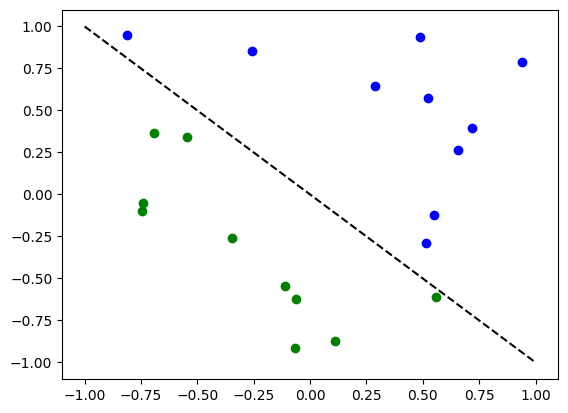

In [ ]:
# We will prepare a simple classification dataset to illustrate the classification algorithms.
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in {0, 1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



# Calssification

## Classification with an EstimatorQNN

We will show how an EstimatorQNN can be used for classification within a NeuralNetworkClassifier. The EstimatorQNN returns one-dimensional output in [-1, +1], suitable for binary classification.

Explain QNNCircuit

### RECALL:

QNN implementation has two main parts:


1.   feature map (encoding component)
2.   Ansantz (parameterized component)



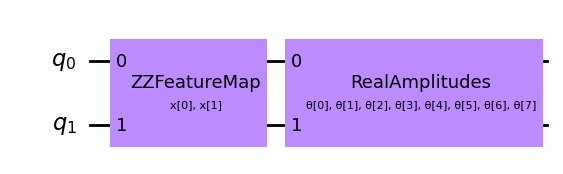

In [ ]:
# construct QNN with the QNNCircuit's default ZZFeatureMap and RealAmplitudes ansatz
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")



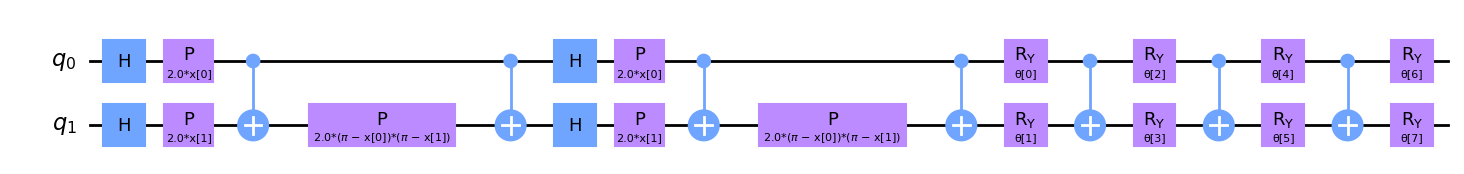

In [ ]:
qc.decompose().draw("mpl", style="clifford")

In [ ]:
# create a quantum neural network
estimator_qnn = EstimatorQNN(circuit=qc)

# test forward pass of the QNN
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))


array([[0.23521988]])

### Callback Function for Visualization

We will add a callback function called callback_graph to visualize the optimization process.

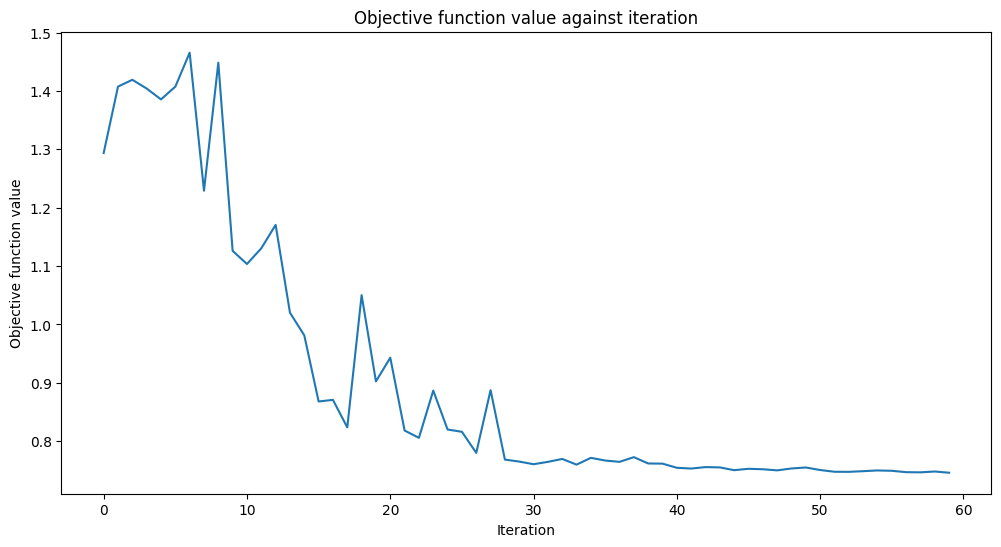

Classification score: 0.8


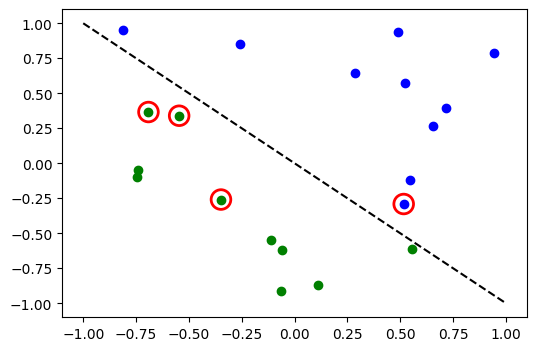

In [ ]:
# define callback function to draw a live plot during optimization
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Classification score:", estimator_classifier.score(X, y))

# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


## Classification with a SamplerQNN

Next, we will show how a SamplerQNN can be used for classification within a NeuralNetworkClassifier. The SamplerQNN returns a multi-dimensional probability vector suitable for **multi-class classification**.

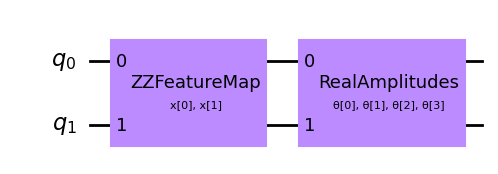

In [ ]:
# construct a quantum circuit from the default ZZFeatureMap and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")



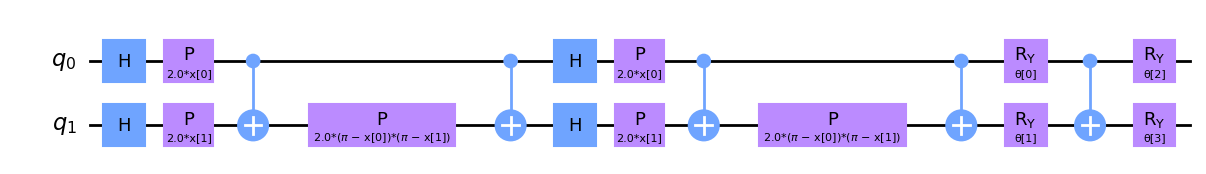

In [ ]:
qc.decompose().draw("mpl", style="clifford")


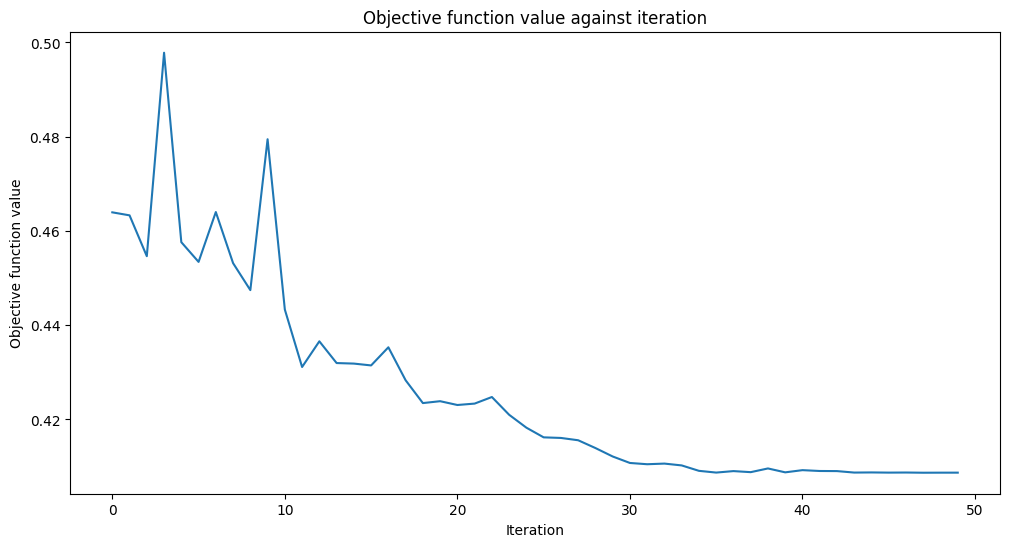

Classification score: 0.75


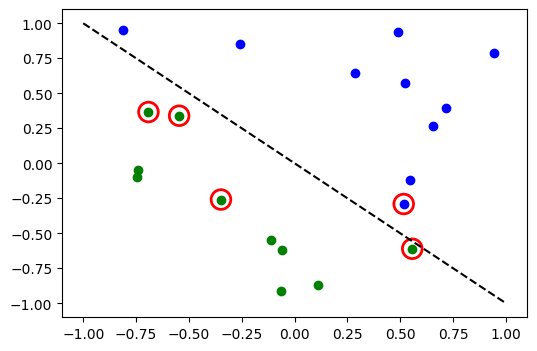

In [ ]:
# parity function maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2  # Number of classes
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=50),
    callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Classification score:", sampler_classifier.score(X, y01))

# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


## Variational Quantum Classifier (VQC)

The VQC is a special variant of the NeuralNetworkClassifier with a SamplerQNN. It uses a parity mapping to classify bitstrings and applies a CrossEntropyLoss function.

In [ ]:
num_inputs

2

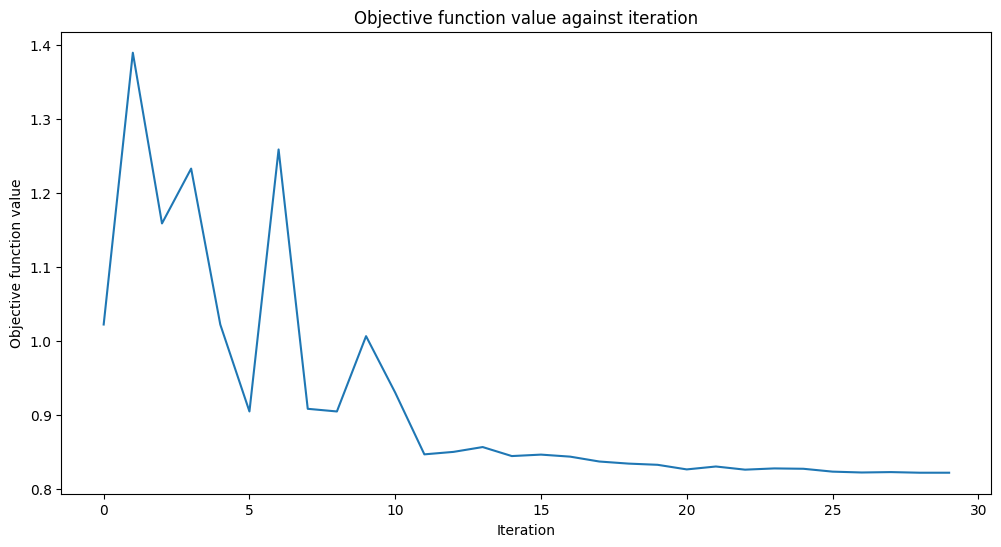

Classification score: 0.8


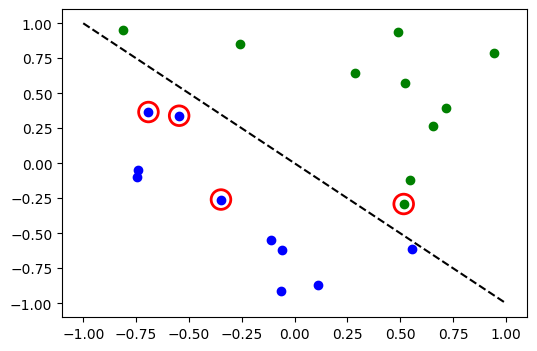

In [ ]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Classification score:", vqc.score(X, y_one_hot))

# evaluate data points
y_predict = vqc.predict(X)

# plot results
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


## Multiple Classes with VQC

We generate a dataset with three classes and train a model to classify the dataset.

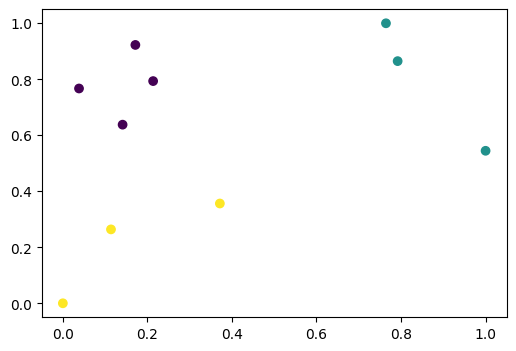

In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)

X = MinMaxScaler().fit_transform(X)

# visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [ ]:

# transform labels to categorical
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"

y_cat

array(['A', 'A', 'B', 'C', 'C', 'A', 'B', 'B', 'A', 'C'], dtype='<U1')

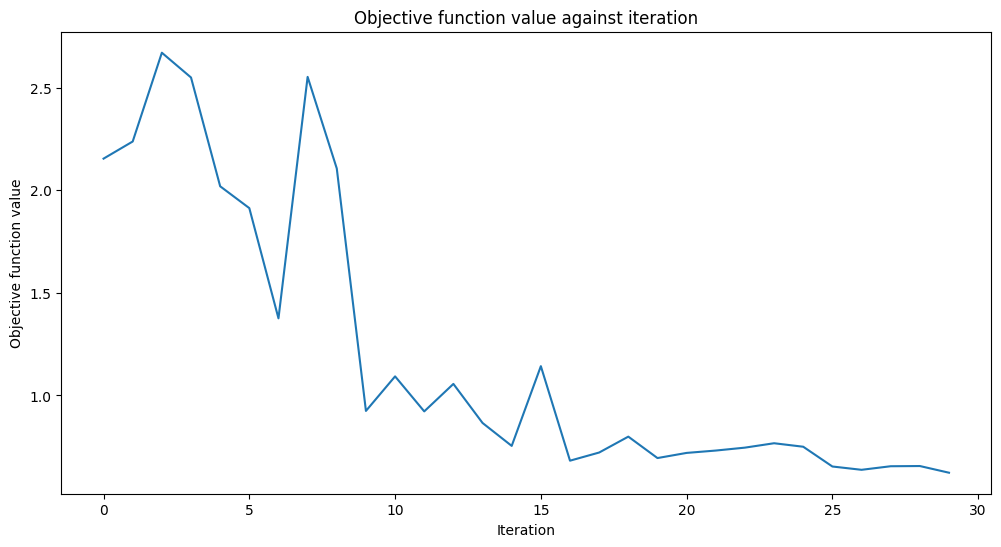

Classification score: 0.9
Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [ ]:
# create and train VQC
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Classification score:", vqc.score(X, y_cat))

# evaluate data points
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")


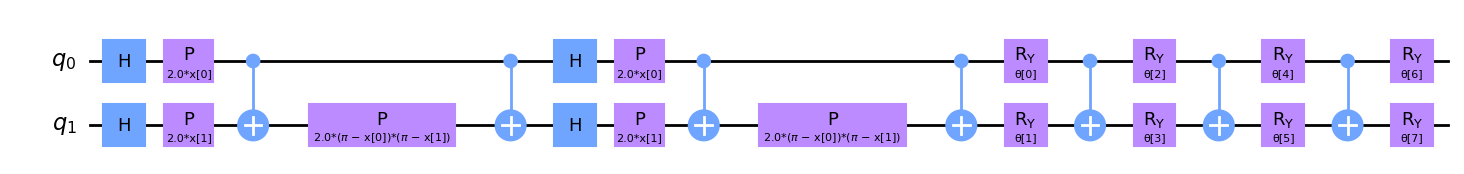

In [ ]:
vqc.neural_network.circuit.decompose().draw("mpl", style="clifford")

# Regression

We prepare a simple regression dataset to illustrate the regression algorithms.


## Generate Dataset for Regression

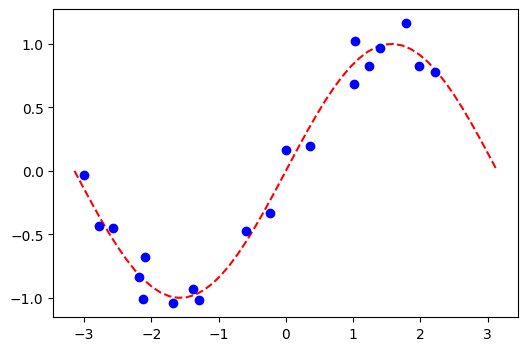

In [ ]:
num_samples = 20
eps = 0.2 #deviation percentage
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()


## Regression with an EstimatorQNN
We will show how an EstimatorQNN can be used for regression within a NeuralNetworkRegressor.

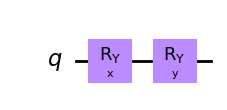

In [ ]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0) # apply param_x degree change on qbit 0

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

qc.draw("mpl", style="clifford")

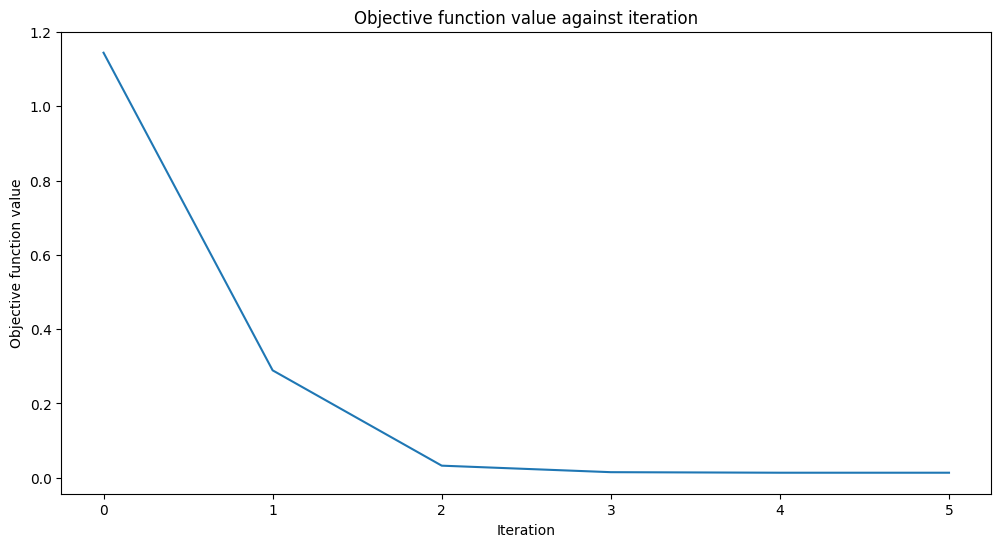

Regression score: 0.9769994291935522


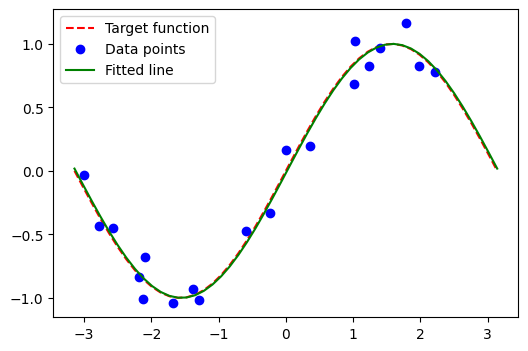

In [ ]:
# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

import matplotlib.pyplot as plt

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# set figure size for plotting
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score regressor
print("Regression score:", regressor.score(X, y))

# plot target function
plt.plot(X_, f(X_), "r--", label='Target function')

# plot data
plt.plot(X, y, "bo", label='Data points')

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-", label='Fitted line')

# adding legend
plt.legend()

# show plot
plt.show()



## Regression with the Variational Quantum Regressor (VQR)

The VQR is a special variant of the NeuralNetworkRegressor with an EstimatorQNN.

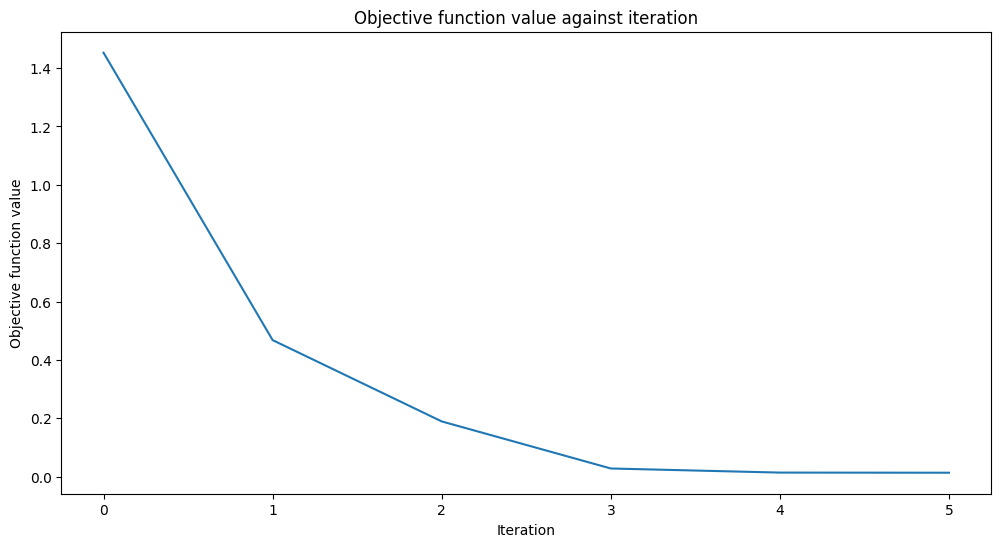

Regression score: 0.9769955693935384


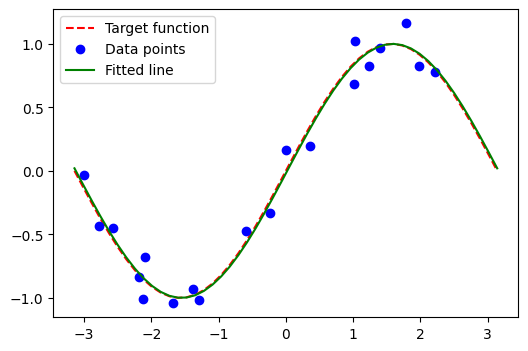

In [ ]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

import matplotlib.pyplot as plt

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# set figure size for plotting
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor to data
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score regressor
print("Regression score:", vqr.score(X, y))

# plot target function
plt.plot(X_, f(X_), "r--", label='Target function')

# plot data
plt.plot(X, y, "bo", label='Data points')

# Plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-", label='Fitted line')

# adding legend
plt.legend()

# show plot
plt.show()



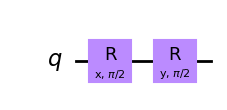

In [ ]:
vqr.neural_network.circuit.decompose().draw("mpl", style="clifford")

# Exercise

## ex1

In [ ]:
# # parameters
# num_samples = 100
# eps = 0.2  # Deviation percentage
# lb, ub = 0, 1 * np.pi

# # generate sample data
# theta = np.linspace(lb, ub, num=50).reshape(50, 1)
# circle_x = lambda theta: np.cos(theta)
# circle_y = lambda theta: np.sin(theta)

# # create random samples within the range [0, pi]
# theta_samples = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
# x_samples = np.cos(theta_samples)+ eps * (2 * algorithm_globals.random.random() - 1)
# y_samples = np.sin(theta_samples) + eps * (2 * algorithm_globals.random.random() - 1)


# plt.rcParams["figure.figsize"] = (12, 6)
# # plot the circle and sample points
# plt.plot(circle_x(theta), circle_y(theta), "r--", label='Circle')
# plt.plot(x_samples, y_samples, "bo", label='Sample Points')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Plot of Sample Points with Deviation on Circle')
# plt.axis('equal')
# plt.legend()
# plt.show()

In [ ]:
# # construct simple feature map
# param_x = Parameter("x")
# feature_map = QuantumCircuit(1, name="fm")
# feature_map.ry(param_x, 0) # apply param_x degree change on qbit 0

# # construct simple ansatz
# param_y = Parameter("y")
# ansatz = QuantumCircuit(1, name="vf")
# ansatz.ry(param_y, 0)

# # construct a circuit
# qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# qc.draw("mpl", style="clifford")

In [ ]:



# # construct QNN
# regression_estimator_qnn = EstimatorQNN(circuit=qc)

# # construct the regressor from the neural network
# regressor = NeuralNetworkRegressor(
#     neural_network=regression_estimator_qnn,
#     loss="squared_error",
#     optimizer=L_BFGS_B(maxiter=20),
#     callback=callback_graph,
# )

# import matplotlib.pyplot as plt

# # create empty array for callback to store evaluations of the objective function
# objective_func_vals = []

# # set figure size for plotting
# plt.rcParams["figure.figsize"] = (12, 6)

# # fit regressor to data
# regressor.fit(x_samples, y_samples)

# # return to default figsize
# plt.rcParams["figure.figsize"] = (6, 4)

# # score regressor
# print("Regression score:", regressor.score(x_samples, y_samples))

# # plot target function
# plt.plot(circle_x(theta), circle_y(theta), "r--", label='Target function')

# # plot data
# plt.plot(x_samples, y_samples, "bo", label='Data points')

# # plot fitted line
# y_ = regressor.predict(circle_x(theta) )
# plt.plot(circle_x(theta) , y_, "g-", label='Fitted line')

# # adding legend
# plt.legend()

# # show plot
# plt.show()



## ex2

In [ ]:
# # parameters for feature map and ansatz
# param_x = Parameter("x")
# param_y = Parameter("y")

# # construct advanced feature map with one qubit
# feature_map = QuantumCircuit(1, name="fm")
# feature_map.ry(param_x, 0)
# feature_map.rz(param_x, 0)
# feature_map.rx(param_x, 0)

# # construct advanced ansatz with one qubit
# ansatz = QuantumCircuit(1, name="vf")
# ansatz.ry(param_y, 0)
# ansatz.rz(param_y, 0)
# ansatz.rx(param_y, 0)

# # construct the QNN circuit
# qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# # draw the circuit with the "mpl" style and "clifford" style
# qc.draw("mpl", style="clifford")


In [ ]:



# # construct QNN
# regression_estimator_qnn = EstimatorQNN(circuit=qc)

# # construct the regressor from the neural network
# regressor = NeuralNetworkRegressor(
#     neural_network=regression_estimator_qnn,
#     loss="squared_error",
#     optimizer=L_BFGS_B(maxiter=20),
#     callback=callback_graph,
# )

# import matplotlib.pyplot as plt

# # create empty array for callback to store evaluations of the objective function
# objective_func_vals = []

# # set figure size for plotting
# plt.rcParams["figure.figsize"] = (12, 6)

# # fit regressor to data
# regressor.fit(x_samples, y_samples)

# # return to default figsize
# plt.rcParams["figure.figsize"] = (6, 4)

# # score regressor
# print("Regression score:", regressor.score(x_samples, y_samples))

# # plot target function
# plt.plot(circle_x(theta), circle_y(theta), "r--", label='Target function')

# # plot data
# plt.plot(x_samples, y_samples, "bo", label='Data points')

# # plot fitted line
# y_ = regressor.predict(circle_x(theta) )
# plt.plot(circle_x(theta) , y_, "g-", label='Fitted line')

# # adding legend
# plt.legend()

# # show plot
# plt.show()

## ex3

In [ ]:
# ##########################################################################################################[third]

# # parameters for feature map and ansatz
# param_x = Parameter("x")
# param_y1 = Parameter("y1")
# param_y2 = Parameter("y2")
# param_y3 = Parameter("y3")
# param_y4 = Parameter("y4")

# # construct advanced feature map with one qubit
# feature_map = QuantumCircuit(1, name="fm")
# feature_map.h(0)  # Apply a Hadamard gate
# feature_map.ry(param_x, 0)
# feature_map.rz(param_x, 0)
# feature_map.rx(param_x, 0)
# feature_map.h(0)  # Apply another Hadamard gate

# # construct advanced ansatz with one qubit
# ansatz = QuantumCircuit(1, name="vf")
# ansatz.ry(param_y1, 0)
# ansatz.rz(param_y1, 0)
# ansatz.rx(param_y1, 0)
# ansatz.ry(param_y2, 0)
# ansatz.rz(param_y2, 0)
# ansatz.rx(param_y2, 0)
# ansatz.h(0)  # add a Hadamard gate to increase entanglement
# ansatz.ry(param_y3, 0)
# ansatz.rz(param_y3, 0)
# ansatz.rx(param_y3, 0)
# ansatz.ry(param_y4, 0)
# ansatz.rz(param_y4, 0)
# ansatz.rx(param_y4, 0)

# # construct the QNN circuit
# qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# # draw the circuit with the "mpl" style and "clifford" style
# qc.draw("mpl", style="clifford")

In [ ]:
# # construct QNN
# regression_estimator_qnn = EstimatorQNN(circuit=qc)

# # construct the regressor from the neural network
# regressor = NeuralNetworkRegressor(
#     neural_network=regression_estimator_qnn,
#     loss="squared_error",
#     optimizer=L_BFGS_B(maxiter=20),
#     callback=callback_graph,
# )

# import matplotlib.pyplot as plt

# # create empty array for callback to store evaluations of the objective function
# objective_func_vals = []

# # set figure size for plotting
# plt.rcParams["figure.figsize"] = (12, 6)

# # fit regressor to data
# regressor.fit(x_samples, y_samples)

# # return to default figsize
# plt.rcParams["figure.figsize"] = (6, 4)

# # score regressor
# print("Regression score:", regressor.score(x_samples, y_samples))

# # plot target function
# plt.plot(circle_x(theta), circle_y(theta), "r--", label='Target function')

# # plot data
# plt.plot(x_samples, y_samples, "bo", label='Data points')

# # plot fitted line
# y_ = regressor.predict(circle_x(theta) )
# plt.plot(circle_x(theta) , y_, "g-", label='Fitted line')

# # adding legend
# plt.legend()

# # show plot
# plt.show()

## ex4

In [ ]:
# # parameters for feature map and ansatz
# param_x = Parameter("x")
# param_y1 = Parameter("y1")
# param_y2 = Parameter("y2")
# param_y3 = Parameter("y3")
# param_y4 = Parameter("y4")
# param_y5 = Parameter("y5")
# param_y6 = Parameter("y6")

# #construct advanced feature map with two qubits
# feature_map = QuantumCircuit(2, name="fm")
# feature_map.h(0)
# feature_map.h(1)
# feature_map.ry(param_x, 0)
# feature_map.rz(param_x, 1)
# feature_map.cx(0, 1)  # Entanglement
# feature_map.rx(param_x, 0)
# feature_map.ry(param_x, 1)

# # construct advanced ansatz with two qubits
# ansatz = QuantumCircuit(2, name="vf")
# ansatz.ry(param_y1, 0)
# ansatz.ry(param_y2, 1)
# ansatz.cz(0, 1)
# ansatz.rx(param_y3, 0)
# ansatz.rz(param_y4, 1)
# ansatz.cx(0, 1)  #   Entanglement
# ansatz.ry(param_y5, 0)
# ansatz.rz(param_y6, 1)

# # construct the QNN circuit
# qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# # draw the circuit with the "mpl" style and "clifford" style
# qc.draw("mpl", style="clifford")

In [ ]:
# # construct QNN
# regression_estimator_qnn = EstimatorQNN(circuit=qc)

# # construct the regressor from the neural network
# regressor = NeuralNetworkRegressor(
#     neural_network=regression_estimator_qnn,
#     loss="squared_error",
#     optimizer=L_BFGS_B(maxiter=20),
#     callback=callback_graph,
# )

# import matplotlib.pyplot as plt

# # create empty array for callback to store evaluations of the objective function
# objective_func_vals = []

# # set figure size for plotting
# plt.rcParams["figure.figsize"] = (12, 6)

# # fit regressor to data
# regressor.fit(x_samples, y_samples)

# # return to default figsize
# plt.rcParams["figure.figsize"] = (6, 4)

# # score regressor
# print("Regression score:", regressor.score(x_samples, y_samples))

# # plot target function
# plt.plot(circle_x(theta), circle_y(theta), "r--", label='Target function')

# # plot data
# plt.plot(x_samples, y_samples, "bo", label='Data points')

# # plot fitted line
# y_ = regressor.predict(circle_x(theta) )
# plt.plot(circle_x(theta) , y_, "g-", label='Fitted line')

# # adding legend
# plt.legend()

# # show plot
# plt.show()